In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_damped_SHM_data, get_damped_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, damped_SHM_dynamics, damped_pendulum_dynamics
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [2]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 5
max_v = 0.5
n_train = 1 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_SHM_data(0.1,time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[2.52795713]
[-0.01546791]


In [ ]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(np.linspace(0.01, 10-0.01, data[0].shape[0]),data[0][:,0], label="q",color="red")
ax1.plot(np.linspace(0.01, 10-0.01, data[0].shape[0]),data[0][:,1], label="p",color="blue")
ax1.set_xlabel("t")
ax1.legend()
ax2.plot(data[0][:,0],data[0][:,1])
ax2.scatter(np.radians(train_starting_position), np.radians(train_starting_velocity),color="red")
#ax2.scatter(train_starting_position, train_starting_velocity,color="red")
ax2.set_xlabel("q")
ax2.set_ylabel("p")
plt.savefig("figures/damped_pendulum_trajectory_1D.pdf")

In [ ]:

eva_future_moi = []
eva_future_inv = []
moi = get_GPR_model(get_MOI(), mean, data, 500)
jitter = 1e-5
try:
    invar_density = 40
    kernel = get_damped_SHM_invariance(5, invar_density, jitter) #switch
    m = get_GPR_model(kernel, mean, data, 500)
except tf.errors.InvalidArgumentError:
    print("jitter too small")

grids = (5, 40)
dynamics = damped_SHM_dynamics
lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = m.log_marginal_likelihood().numpy()
grid_moi = (evaluate_model_grid(moi, grids, dynamics))
grid_inv = (evaluate_model_grid(m, grids, dynamics))
print(lml_moi)
print(lml_inv)

for i in range(3):
    print(i)
    test_starting_position = (np.random.uniform(-max_x, max_x))
    test_starting_velocity = (np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting)
    eva_future_moi.append(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(m, test_starting, dynamics,time_setting)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])



In [9]:

print("Baseline RBF & " + format((lml_moi),".2f")+" & "+format(np.mean(eva_future_moi),".4f")+" & "+format((grid_moi),".4f")+' \\\\')
print("Invariance Kernel & "+ format((lml_inv),".2f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((grid_inv),".4f")+ ' \\\\')
print(m.kernel.epsilon.numpy())

Baseline RBF & 68.95 & 4.6933 & 8.1191 \\
Invariance Kernel & 74.80 & 3.7091 & 7.6905 \\
0.045689625158137924


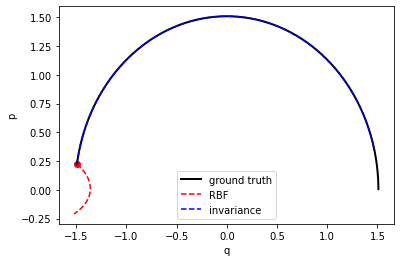

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="invariance", color="blue")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/damped_shm_predicted_trajectory.pdf")

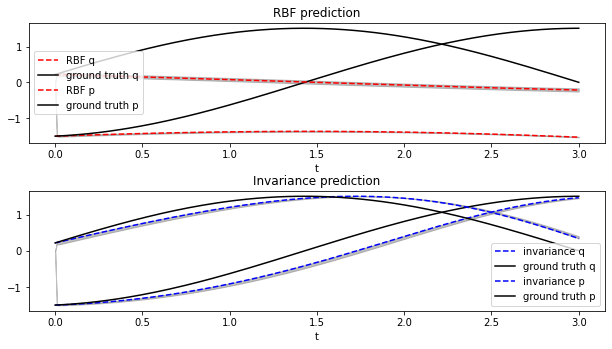

In [46]:

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,5))
t = np.linspace(0, testing_time, int(testing_time/time_step))
ax1.plot(t,evaluate_moi[1][:,0],'--',label="RBF q", color="red" )
ax1.plot(t, evaluate_moi[4][:,0], label="ground truth q", color="black")
ax1.fill_between(t,evaluate_moi[2][:,0],evaluate_moi[3][:,0], color="grey", alpha=0.5)
ax1.plot(t,evaluate_moi[1][:,1],'--',label="RBF p", color="red")
ax1.plot(t, evaluate_moi[4][:,1], label="ground truth p", color="black")
ax1.fill_between(t,evaluate_moi[2][:,1],evaluate_moi[3][:,1], color="grey", alpha=0.5)
ax1.set_xlabel("t")
ax1.set_title("RBF prediction")
ax1.legend()

ax2.plot(t,evaluate_invariance[1][:,0], '--', label="invariance q", color="blue")
ax2.plot(t, evaluate_moi[4][:,0],label="ground truth q", color="black")
ax2.fill_between(t,evaluate_invariance[2][:,0],evaluate_invariance[3][:,0], color="grey", alpha=0.5)
ax2.plot(t,evaluate_invariance[1][:,1], '--', label="invariance p", color="blue")
ax2.plot(t, evaluate_moi[4][:,1],label="ground truth p", color="black")
ax2.fill_between(t,evaluate_invariance[2][:,1],evaluate_invariance[3][:,1], color="grey", alpha=0.5)
ax2.set_xlabel("t")
ax2.set_title("Invariance prediction")
ax2.legend()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/damped_shm_predicted_trajectory_seperate.pdf")